Jonathan Elsner \
October 17th, 2024

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pint
import pint_pandas

pint_pandas.PintType.ureg.setup_matplotlib()

In [2]:
units = pint_pandas.PintType.ureg

w = channel_width = 5.5 * units.cm
g = 9.81 * units.m / units.s**2
water_density = 997 * units.kg / units.m**3

# Hydraulic Jump

## Part 1

In supercritical water flow, the water is uniform, relatively smooth, but with standing surface gravity waves due to the walls of the channel. In subcritical water flow, the water flow is slower moving with a rougher surface and greater depth.

## Part 2

![Point tracking used to determine the water level.](./lab3_image_analysis_thumbnail.png)

Data Analysis:

In [3]:
measured_volume = 350 * units.ml
measured_time = 2.13 * units.s
Q = measured_volume / measured_time

In [4]:
depths = pd.read_csv('lab3_image_data.csv', header=0, names={'h': 'y'})
depths.index = -depths.index.astype('pint[cm]')
depths['h'] = depths['h'].astype('pint[cm]')
depths

,h
-0.0148,0.299
0.548,0.326
1.05,0.333
1.6,0.347
2.15,0.362
...,...
29.6,1.73
30.0,1.79
30.6,1.55
31.1,1.63


In [5]:
depths['A'] = depths['h'] * channel_width
depths['U_avg'] = (Q / depths['A']).pint.to_reduced_units()
depths['froude'] = (depths['U_avg'] / np.sqrt(g * depths['h'])).pint.to_reduced_units()
depths['PE'] = (water_density * g * depths['h']).pint.to('J/m^3')
depths['KE'] = (0.5 * water_density * depths['U_avg']**2).pint.to('J/m^3')
depths['E'] = depths['PE'] + depths['KE']

In [6]:
depths

,h,A,U_avg,froude,PE,KE,E
-0.0148,0.299,1.6444999999999999,99.92049183720955,5.834242347542155,29.2439043,497.70761874614465,526.9515230461446
0.548,0.326,1.7930000000000001,91.64486828014003,5.124657528909006,31.8846582,418.6792768218982,450.5639350218982
1.05,0.333,1.8315000000000001,89.71839957755451,4.963921415047591,32.569298100000005,401.262152454473,433.831450554473
1.6,0.347,1.9084999999999999,86.09863705857538,4.666561949459919,33.9385779,369.53681887171285,403.47539677171284
2.15,0.362,1.9909999999999999,82.53101397603773,4.379538937670646,35.4056634,339.5467081554598,374.95237155545976
...,...,...,...,...,...,...,...
29.6,1.73,9.515,17.269495410014827,0.41920079059173676,169.203861,14.867038265068679,184.07089926506868
30.0,1.79,9.845,16.69062964208137,0.3983012792446929,175.072203,13.887069324778894,188.9592723247789
30.6,1.55,8.525,19.274985199564938,0.4943035169636894,151.598835,18.520523964005854,170.11935896400587
31.1,1.63,8.965,18.32897365602801,0.4583633038418654,159.423291,16.74717107287593,176.17046207287592


In [7]:
depths.dtypes

h                  pint[centimeter]
A             pint[centimeter ** 2]
U_avg     pint[centimeter / second]
froude          pint[dimensionless]
PE         pint[joule / meter ** 3]
KE         pint[joule / meter ** 3]
E          pint[joule / meter ** 3]
dtype: object

In [8]:
hydraulic_jump_location = 17.5 * units.cm

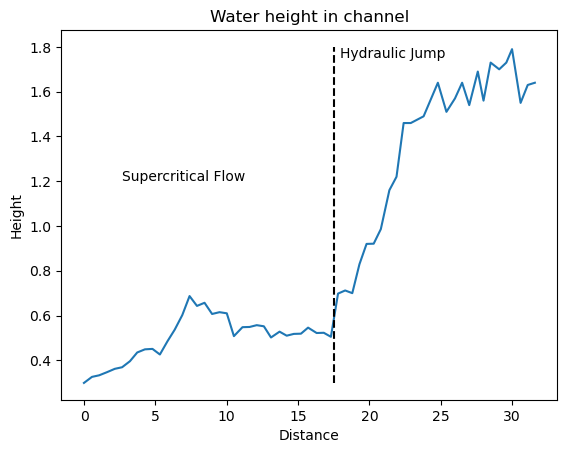

In [9]:
ax = depths.h.plot()

ax.text(7, 1.2, 'Supercritical Flow', horizontalalignment='center')

ax.vlines(hydraulic_jump_location, 0.3, 1.8, linestyle='--', color='black')
ax.text(hydraulic_jump_location * 1.025, 1.75, 'Hydraulic Jump')

ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax.set_title('Water height in channel')
plt.show()

## Part 3


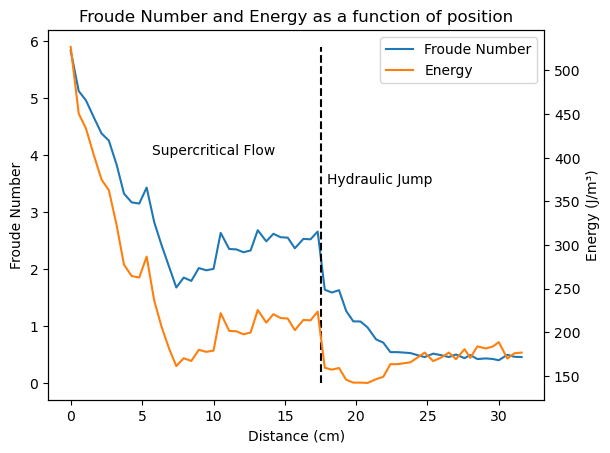

In [10]:
fig, ax = plt.subplots()
f_line, = ax.plot(depths.index, depths['froude'], label="Froude Number")

e_ax = ax.twinx()
e_line, = e_ax.plot(depths.index, depths['E'], label='Energy', color='tab:orange')
e_ax.set_ylabel(f'Energy ({depths['E'].pint.units:~P})')

ax.text(10, 4, 'Supercritical Flow', horizontalalignment='center')

ax.vlines(hydraulic_jump_location, 0, 5.9, linestyle='--', color='black')
ax.text(hydraulic_jump_location * 1.025, 3.5, 'Hydraulic Jump')

ax.legend(handles=[f_line, e_line])
ax.set_xlabel(f'Distance ({depths.index.to_series().pint.units:~P})')
ax.set_ylabel('Froude Number')
ax.set_title('Froude Number and Energy as a function of position')

plt.show()

## Part 4

When the hydraulic jump occurs, Energy drops because the average velocity of the water decreases. Energy isn't conserved because some is lost is heat due to viscous forces on the walls and in the turbulence.

## Part 5

![Sketch of the control volume around the hydraulic jump](./hw3-1-6-schematic.png)

Here we go! Let's do a derivation!

Starting from Reynold's transport theorem, with conservation of momentum:

$$\begin{split}
\frac{d}{dt} \int_{V^*}\rho \vec u dV = \int_{V^*} \rho \vec g dV + \int_{A*}P dA + \int_{A^*} \rho \vec u (-\vec u \cdot \vec n) dA &= 0 \\
0 + \rho w \left(\int_0^{h_1} g(h_1 - h) dh - \int_0^{h_2} g(h_2 - h) dh \right) + \rho \left[\vec u_1 (-\vec u_1 \cdot \vec n_1) A_1 + \vec u_2 (-\vec u_2 \cdot \vec n_2 ) A_2 \right] &= 0 \\
\rho w g\left[\left(h_1^2 - \frac{h_1^2}{2}\right) - \left(h_2^2 - \frac{h_2^2}{2}\right) \right] + \rho w \left[u_1^2 h_1 - u_2^2 h_2\right] &= 0 \\
g(h_2^2 - h_1^2) - 2(u_1^2 h_1 - u_2^2 h_2) &= 0 \\

\end{split}$$

## Part 6

Denoting flow rate per unit width as $ Q = u_1 h_1 = u_2 h_2 $ due to conservation of mass:

$$\begin{split}
g(h_2^2 - h_1^2) - 2Q^2\left(\frac{1}{h_1} - \frac{1}{h_2}\right) &= 0 \\
g h_1 h_2 (h_2 + h_1)(h_2 - h_1) - 2Q^2 (h_2 - h_1) &= 0 \\
g h_1 h_2 (h_2 + h_1) - 2Q^2 &= 0 \\
(h_2 + h_1) - \frac{2(u_1 h_1)^2}{g h_1 h_2} &= 0 \\
\end{split}$$

using the fact that $\text{Fr}_1^2 = u_1^2/gh_1$,

$$\begin{split}
(h_2 + h_1) - \frac{2 h_1^2}{h_2} \text{Fr}_1^2 &= 0 \\
\frac{h_2^2}{h_1^2} + \frac{h_2}{h_1} - 2 \text{Fr}_1^2 &= 0
\end{split}$$

This is quadratic in $h_2/h_1$, so using the quadratic formula, we obtain the result:

$$ \frac{h_2}{h_1} = \frac{1}{2}\left(\sqrt{1 + 8\text{Fr}_1^2} - 1 \right) $$

## Part 7

In [11]:
data = pd.read_csv('./lab3_data.csv', header=[0,1])
data = data.pint.quantify(level=-1) # Retrieve units using pint

In [12]:
data['Q'] = data['V'] / data['t']
data['U_avg_1'] = (data['Q'] / (data['h_1'] * channel_width)).pint.to_reduced_units()
# data['U_avg_2'] = (data['Q'] / (data['h_2'] * channel_width)).pint.to_reduced_units()
data['froude_1'] = (data['U_avg_1'] / np.sqrt(g * data['h_1'])).pint.to_reduced_units()
# data['froude_2'] = (data['U_avg_2'] / np.sqrt(g * data['h_2'])).pint.to_reduced_units()

In [13]:
data

,V,t,h_1,h_2,Q,U_avg_1,froude_1
0,475,2.64,0.8,2.0,179.9242424242424,40.89187327823691,1.459679501098389
1,490,2.33,0.6,2.5,210.30042918454936,63.72740278319678,2.6267339678594315
2,525,2.09,0.7,2.4,251.19617224880383,65.24575902566333,2.4898246604367227
3,535,2.03,0.9,2.7,263.54679802955667,53.24177737970842,1.7918299307040284
4,350,2.13,0.5,1.5,164.3192488262911,59.75245411865131,2.697964564148627


In [14]:
data.dtypes

V                    pint[milliliter]
t                        pint[second]
h_1                  pint[centimeter]
h_2                  pint[centimeter]
Q           pint[milliliter / second]
U_avg_1     pint[centimeter / second]
froude_1          pint[dimensionless]
dtype: object

In [15]:
def height_ratio(froude):
    """Computes the ratio of the depths of water before and after hydraulic jump for the given Froude Number"""
    return 0.5 * (np.sqrt(1 + 8 * froude**2) - 1)

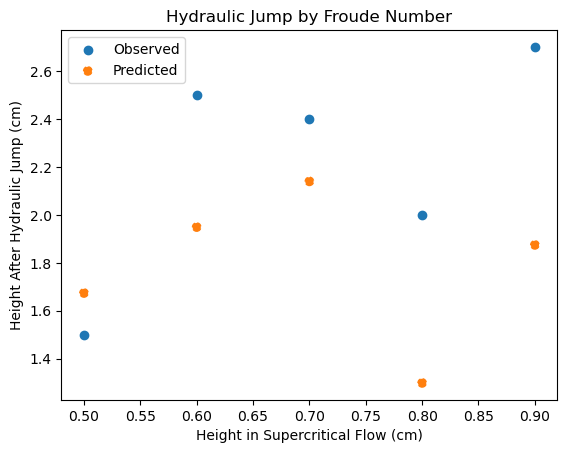

In [16]:
ax = plt.gca()

ax.scatter(data['h_1'], data['h_2'], label='Observed')

ax.scatter(data['h_1'], height_ratio(data['froude_1']) * data['h_1'], linestyle='--', color='tab:orange', label='Predicted')

ax.set_title('Hydraulic Jump by Froude Number')
ax.set_xlabel('Height in Supercritical Flow (cm)')
ax.set_ylabel('Height After Hydraulic Jump (cm)')
ax.legend()

plt.show()

Okay the data is so noisy that it makes it hard to realize any kind of functional correlation like a linear map, but the broad trend is that the observed hydraulic jump is larger than predicted. This makes sense since we assumed momentum is conserved, even though it is not due to viscous forces along the walls of the channel. Assuming the lost momentum is due to a decrease in velocity, returning to the last line of Part 1.6, we see that in reality,

$$\begin{split}
g(h_2^2 - h_1^2) &\leq 2(u_1^2 h_1 - u_2^2 h_2)\\
\end{split}$$

Since $u_1 - u_2$ is greater than predicted. Propagating this inequality through the derivation, we find:

$$ 
\frac{h_2^2}{h_1^2} + \frac{h_2}{h_1} - 2 \text{Fr}_1^2 \leq 0
$$

Since this is quadratic in $h_2/h_1$, intuitively, this means that the parabola is translated down from where we predicted it to be, hence the positive solution will be further to the right than predicted. Since the solution is the ratio of the initial and final heights, a greater ratio means the observed final height is greater than predicted.

# Streamlines, strain, and rotation rate tensors

## Part 1

Since $ \vec u = \langle x^2/y, y^2/x \rangle $, then

$$\begin{split}
\frac{dx}{x^2/y} &= \frac{dy}{y^2/x} \\
y \frac{dx}{x^2} &= x \frac{dy}{y^2} \\
\int_{x_0}^x \frac{dx}{x^3} &= \int_{y_0}^y \frac{dy}{y^3} \\
\frac{1}{2x^2} - \frac{1}{2x_0^2} &= \frac{1}{2y^2} - \frac{1}{2y_0^2} \\
\frac{1}{x^2} - \frac{1}{x_0^2} &= \frac{1}{y^2} - \frac{1}{y_0^2} \\
\end{split}$$


## Part 2

The strain rate tensor is:

$$ S = \begin{bmatrix}1 & -\frac{17}{8} \\ -\frac{17}{8} & 4\end{bmatrix}$$

and the rotation rate tensor is:

$$ R = \begin{bmatrix}0 & \frac{15}{4} \\ \frac{15}{4} & 0\end{bmatrix}$$

## Part 3

![How a parcel of water transforms at (1,2) under the specified velocity vector field.](./1_3_sketch.png)

First the parcel translates up and to the right a little. Second, the volume increases, because the trace of the strain matrix is positive. The parcel rotates clockwise because the rotation matrix is negative of the standard rotation matrix. Finally the strain makes the parcel lean backwards and downwards.